# TM10007 Assignment

In [34]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Load and analyse data

In [35]:
from load_data import load_data
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import shapiro

# Code used to load the original data and split into train and test set
# Was only run once at the start to create test and train dataset

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

print(data.info())

# Seperate the labels from the values
labels = data['label']
values = data.drop(columns=['label'])

# Convert 'GIST' and 'non-GIST' to numeric values
labels = labels.map({'GIST': 1, 'non-GIST': 0})

counter = 0
for feature in values.columns:
    stat, p_value = shapiro(values[feature])
    if p_value < 0.05:
        counter += 1
print(f'The number of features that are not normally distributed: {counter}')


The number of samples: 246
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, GIST-001_0 to GIST-246_0
Columns: 494 entries, label to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25), object(1)
memory usage: 951.3+ KB
None
The number of features that are not normally distributed: 443


c:\Users\lisan\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


## Feature selection and dimension reduction

In [36]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

def preprocess_train_test(training_values, test_values):
    # First we remove NaNs by averaging
    training_values = training_values.fillna(training_values.mean())
    test_values = test_values.fillna(training_values.mean())

   # Remove features with zero variance
   # Initialize the VarianceThreshold selector
    selector = VarianceThreshold(threshold=0) 

    # Fit the selector on the training data
    training_non_zero_var = selector.fit_transform(training_values)
    training_values = pd.DataFrame(training_non_zero_var, columns=training_values.columns[selector.get_support()], index=training_values.index)

    # Apply the same transformation to the test data
    test_non_zero_var = selector.transform(test_values)
    test_values = pd.DataFrame(test_non_zero_var, columns=test_values.columns[selector.get_support()], index=test_values.index)

    # Standardize the training & testing data separately
    scaler = StandardScaler()
    scaled_training_values = scaler.fit_transform(training_non_zero_var)

    training_values = pd.DataFrame(scaled_training_values, columns=training_values.columns, index=training_values.index)

    scaled_test_values = scaler.transform(test_non_zero_var)
    test_values = pd.DataFrame(scaled_test_values, columns=test_values.columns, index=test_values.index)

    return training_values, test_values

"""
# Now we can run the logistic regression model for each feature to get its correlation with the label
p_values = {}

for column in values.columns:
    logit_model = sm.Logit(labels, values[column])
    result = logit_model.fit()

    p_values[column] = result.pvalues[column]

print(p_values)

# Now we remove highly correlated features
# Make a correlation matrix to analyse the correlation between the features
correlation_matrix = values.corr().abs()

# Heatmap for the entire correlation matrix (for large datasets, consider reducing the size)
plt.figure(figsize=(15, 15))  # Adjust size as needed
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.show()

features_to_remove = []

for feature1 in correlation_matrix.columns:
    for feature2 in correlation_matrix.columns:
        if feature1 != feature2 and feature1 not in features_to_remove and feature2 not in features_to_remove:
            if correlation_matrix[feature1][feature2] > 0.95:
                # Remove the feature with the higher p-value
                if p_values[feature1] < p_values[feature2]:
                    features_to_remove.append(feature1)
                else:
                    features_to_remove.append(feature2)

values = values.drop(columns=features_to_remove)

correlation_matrix_2 = values.corr().abs()

# Heatmap for the entire correlation matrix (for large datasets, consider reducing the size)
plt.figure(figsize=(15, 15))  # Adjust size as needed
sns.heatmap(correlation_matrix_2, annot=False, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.show()
"""

'\n# Now we can run the logistic regression model for each feature to get its correlation with the label\np_values = {}\n\nfor column in values.columns:\n    logit_model = sm.Logit(labels, values[column])\n    result = logit_model.fit()\n\n    p_values[column] = result.pvalues[column]\n\nprint(p_values)\n\n# Now we remove highly correlated features\n# Make a correlation matrix to analyse the correlation between the features\ncorrelation_matrix = values.corr().abs()\n\n# Heatmap for the entire correlation matrix (for large datasets, consider reducing the size)\nplt.figure(figsize=(15, 15))  # Adjust size as needed\nsns.heatmap(correlation_matrix, annot=False, cmap=\'coolwarm\', fmt=".2f", cbar_kws={\'label\': \'Correlation Coefficient\'})\nplt.show()\n\nfeatures_to_remove = []\n\nfor feature1 in correlation_matrix.columns:\n    for feature2 in correlation_matrix.columns:\n        if feature1 != feature2 and feature1 not in features_to_remove and feature2 not in features_to_remove:\n    

## Elastic net selection

In [37]:
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

def elastic_net_feature_selection(training_values, training_labels):

    elastic_net = LogisticRegressionCV(
    penalty="elasticnet",
    solver="saga",         
    l1_ratios=[0.8],  
    cv=5,                 
    max_iter=5000,         
    random_state=42
    )   

    elastic_net.fit(training_values, training_labels)

    selected_features = np.where(elastic_net.coef_ != 0)[0]

    print(f"{len(selected_features)} features selected out of {len(training_values.columns)}")

    training_values = training_values.iloc[:, selected_features]

    return training_values, training_labels

## ALSO: code voor sequential feature selection
#sfs = SequentialFeatureSelector(model, n_features_to_select=10, direction='forward', n_jobs=-1)
#sfs.fit(X_train, y_train)


## Random forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

def train_random_forest(training_values, training_labels):
    # Initialize the Random Forest Classifier
    param_grid = {
        'n_estimators': randint(1, 100),
        'max_depth': randint(1, 20),
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': randint(1, 10)
        }
    
    random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, random_state=42)

    random_search.fit(training_values, training_labels)
    print(f"Best hyperparameters: {random_search.best_params_}")

    # Return best model's cross-validation score
    best_model = random_search.best_estimator_

    feature_importances = best_model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': training_values.columns,
        'Importance': feature_importances
    })

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

    all_scores = []
    for i in range(1, 493):
        top_features = feature_importance_df.head(20)['Feature'].values

        data_selected = training_values[top_features]
        labels_selected = training_labels

        final_model = best_model.fit(data_selected, labels_selected)
        cv_scores = cross_val_score(best_model, data_selected, labels_selected, cv=5)
        all_scores.append(cv_scores.mean())

    # Plot the cross-validation scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 493), all_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Top Features')
    plt.ylabel('Cross-Validation Score')
    plt.title('Cross-Validation Score vs Number of Top Features')
    plt.grid(True)
    plt.show()

    return final_model, cv_scores.mean()

## KNN-classifier

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

def KNN(training_values, training_labels):
    #training_values, training_labels = elastic_net_feature_selection(training_values, training_labels)

    param_grid = {
    'n_neighbors': randint(1, 100),
    'weights': ['uniform', 'distance']
    }

    random_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_grid, n_iter=20, cv=5, n_jobs=-1, random_state=42)

    random_search.fit(training_values, training_labels)
    print(f"Best hyperparameters: {random_search.best_params_}")

    # Return best model's cross-validation score
    best_model = random_search.best_estimator_
    print(best_model)
    cv_scores = cross_val_score(best_model, training_values, training_labels, cv=5)

    return cv_scores.mean()


## SVM

In [40]:
# from sklearn.svm import SVC
# from sklearn.model_selection import RandomizedSearchCV, cross_val_score

# def SVM(training_values, training_labels):
#     #training_values, training_labels = elastic_net_feature_selection(training_values, training_labels)

#     param_grid = {
#         'C': [0.1,0.5,1,5,10,25,50], # Use a wide range of slacks
#         'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], # the used kernels
#         'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # SLack variable per object 
#         'degree': [2, 3, 4],  # Only used for 'poly' kernel
#     }

#     random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid,n_iter=50, cv=5, n_jobs=-1, random_state=42)

#     random_search.fit(training_values, training_labels)
#     print(f"Best hyperparameters: {random_search.best_params_}")

#     # Return best model's cross-validation score
#     best_model = random_search.best_estimator_
#     print(best_model)
#     cv_scores = cross_val_score(best_model, training_values, training_labels, cv=5)

    # return cv_scores.mean()

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import learning_curve

def SVM(training_values, training_labels):
    clf = SVC()

    # Define hyperparameters
    param_grid = {
        'C': [0.1, 0.5, 1, 5, 10, 25, 50], 
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'degree': [2, 3, 4],
    }

    # Optimize model with n_iter=100 to find best hyperparameters
    random_search = RandomizedSearchCV(
        clf, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, random_state=42
    )
    random_search.fit(training_values, training_labels)
    best_params = random_search.best_params_
    print(f"Best hyperparameters found: {best_params}")

    # Look at the performance with different iteration values
    iterations = [10, 20, 30, 40, 50, 75, 100]
    scores = []

    for i in iterations:

        random_search_iter = RandomizedSearchCV(
            clf, param_distributions=param_grid, n_iter=i, cv=5, n_jobs=-1, random_state=42
        )

        random_search_iter.fit(training_values, training_labels)
        best_model = random_search_iter.best_estimator_
        cv_score = cross_val_score(best_model, training_values, training_labels, cv=5).mean()
        
        scores.append(cv_score)

    # Plot results
    plt.figure(figsize=(8,5))
    plt.plot(iterations, scores, marker='o', linestyle='-', color='b', label="Validation Accuracy")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cross-Validation Accuracy")
    plt.title("SVM Performance vs. Number of Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()

    train_sizes, train_scores, validation_scores = learning_curve(
        best_model, training_values, training_labels, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calculate the mean and standard deviation of the scores
    train_mean = train_scores.mean(axis=1)
    validation_mean = validation_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    validation_std = validation_scores.std(axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, label="Training score", color="r")
    plt.plot(train_sizes, validation_mean, label="Cross-validation score", color="g")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)
    plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="g", alpha=0.2)

    # Adding labels and title
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    plt.ylim(0.3, 1.01)
    plt.title("Learning Curve for SVM")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    return cv_score.mean()

## Linear classifier

In [41]:
# Linear classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.decomposition import PCA

def linear_classifier(training_values,training_labels):
    # First we do a PCA
    pca = PCA(n_components=2)  # You can set n_components to the number of components you want
    principal_components = pca.fit_transform(training_values)

    # Step 3: Create a DataFrame of principal components
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2']) 

    # Plot the two principal components against each other
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, c=training_labels, cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA: Principal Component 1 vs Principal Component 2')
    plt.grid(True)
    plt.show()

    # # === LDA model trainen ===
    param_grid = {
        'solver': ['lsqr', 'eigen'],  # Solver types for LDA
        'shrinkage': [None, 'auto'],  # Shrinkage types for LDA
    }

    random_search = RandomizedSearchCV(LinearDiscriminantAnalysis(), param_distributions=param_grid,n_iter=4, cv=5, n_jobs=-1, random_state=42)

    random_search.fit(pca_df, training_labels)
    print(f"Best hyperparameters: {random_search.best_params_}")

    # Return best model's cross-validation score
    best_model = random_search.best_estimator_
    print(best_model)
    cv_scores = cross_val_score(best_model, training_values, training_labels, cv=5)
    
    return cv_scores.mean()


## Try the different classifiers for 5 different folds


=== Fold 0 ===


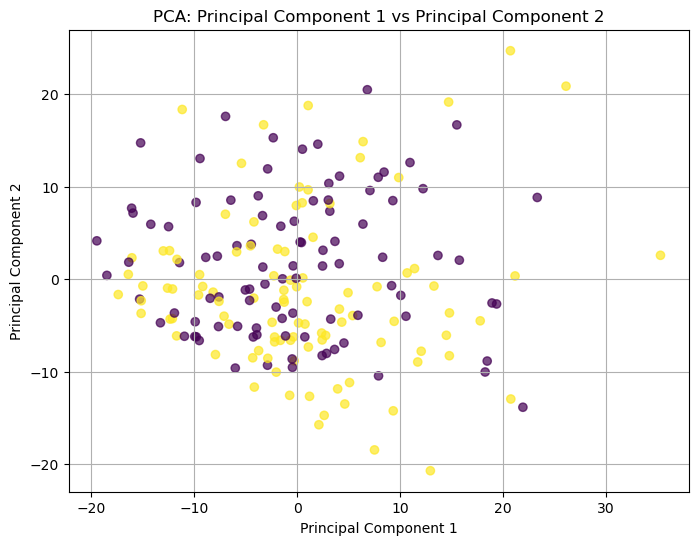

Best hyperparameters: {'solver': 'lsqr', 'shrinkage': 'auto'}
LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')
Fold 0 - LDA Score: 0.5556

=== Fold 1 ===


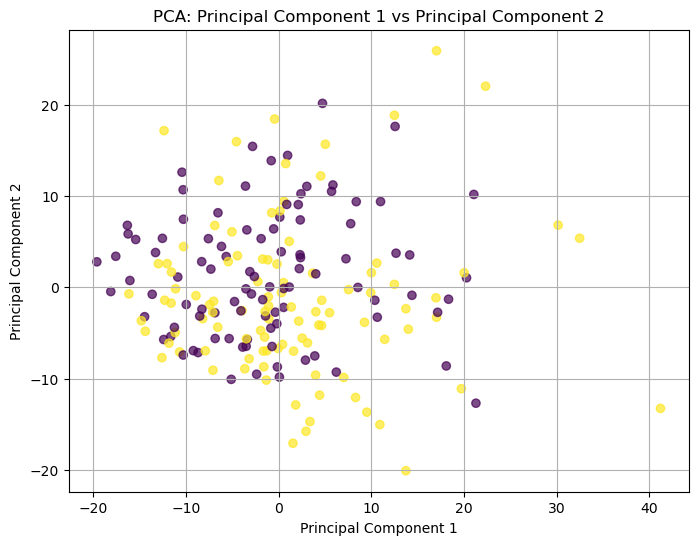

Best hyperparameters: {'solver': 'lsqr', 'shrinkage': 'auto'}
LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')
Fold 1 - LDA Score: 0.5838

=== Fold 2 ===


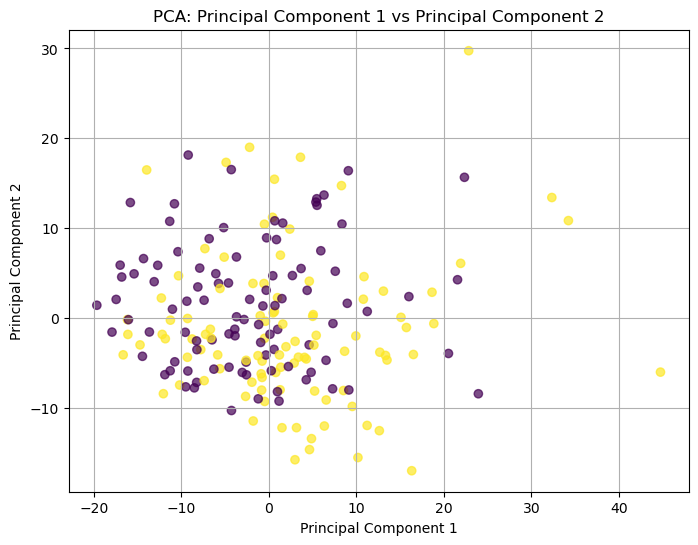

Best hyperparameters: {'solver': 'lsqr', 'shrinkage': None}
LinearDiscriminantAnalysis(solver='lsqr')
Fold 2 - LDA Score: 0.5695

=== Fold 3 ===


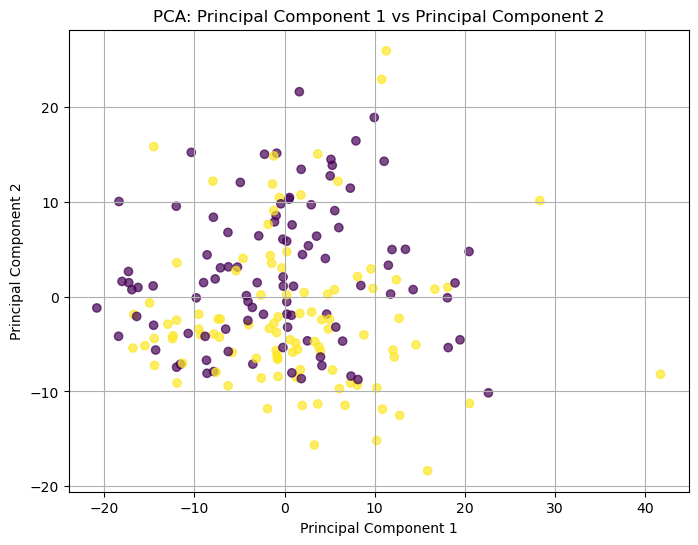

Best hyperparameters: {'solver': 'lsqr', 'shrinkage': 'auto'}
LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')
Fold 3 - LDA Score: 0.5682

=== Fold 4 ===


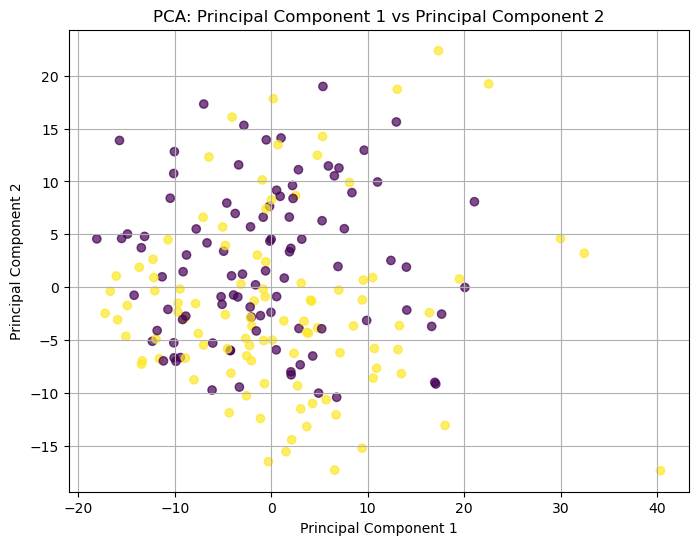

Best hyperparameters: {'solver': 'lsqr', 'shrinkage': 'auto'}
LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')
Fold 4 - LDA Score: 0.5979


In [42]:
from sklearn.model_selection import StratifiedKFold

# 5-fold cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(values, labels)):
    print(f"\n=== Fold {fold} ===")

    training_values = values.iloc[train_index]
    training_labels = labels[train_index]

    test_values = values.iloc[test_index]
    test_labels = labels[test_index]

    training_values, test_values = preprocess_train_test(training_values, test_values)

    # Now train the classifiers

    #forest_model, forest_score = train_random_forest(training_values, training_labels)
    #print(f"Fold {fold} - Random Forest Score: {forest_score:.4f}")

    #knn_score = KNN(training_values, training_labels)
    #print(f"Fold {fold} - KNN Score: {knn_score:.4f}")

    #svm_score = SVM(training_values, training_labels)
    #print(f"Fold {fold} - SVM Score: {svm_score:.4f}")

    lda_score = linear_classifier(training_values, training_labels)
    print(f"Fold {fold} - LDA Score: {lda_score:.4f}")
    
#)